In [1]:
%matplotlib inline
import os

import numpy as np
from time import time
from scipy.stats import norm
import scipy.linalg as scl
from random import random, seed
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn import datasets
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier #For Classification
from sklearn.neural_network import MLPRegressor #For Regression

#import tensorflow and keras:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

#imports from local classes
from src.statistical_functions import *
from src.data_processing import Data
from src.print_and_plot import *
from src.regression_methods import Fitting
from src.resampling_methods import Resampling
from src.neuralnetwork import NeuralNetwork
from src.keras_NN import create_neural_network_Keras


#add autoreload in order to change classes live, and run without restaring kernel everytime
#still need to run the import again
%load_ext autoreload
%autoreload

# Running the .py programs created for some of the tasks

#### The different .py files contain several user defined options, e.g. you can decide to use SGD or GD etc. The project2 README file contains which options have been used for this example run. Change these options in the files to study the different cases.

### Task a:

--------  SGD + Ridge  -------
Scores:
Training MSE:
0.028591667405942378
Training R2:
0.9713976942895677
Test MSE:
0.030208149478611356
Test R2:
0.9696594574243784


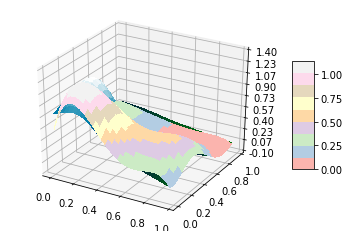

In [2]:
run Task_a.py

### Task b:

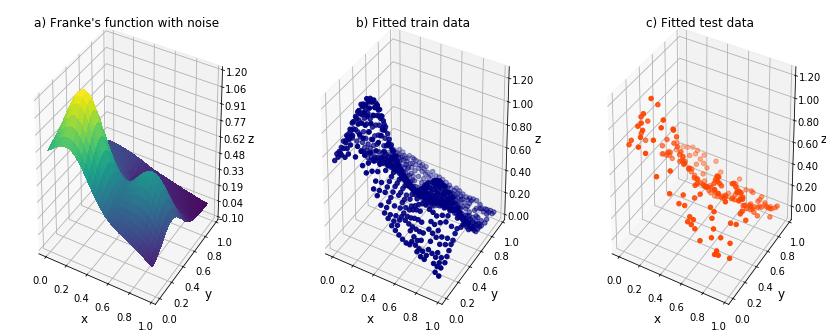

Scores:
Training MSE:
0.001093956456072549
Training R2:
0.9989368511773196
Test MSE:
0.002840061609611545
Test R2:
0.9967104427452765


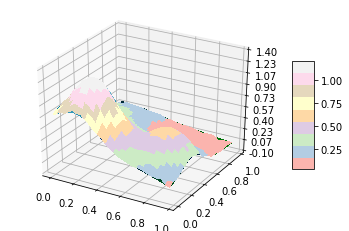

In [3]:
run Task_b.py

### Task c:

Scores:
Training MSE:
0.0038755613309544097
Training R2:
0.9962335809223866
Test MSE:
0.09134505095199298
Test R2:
0.8941977969684558


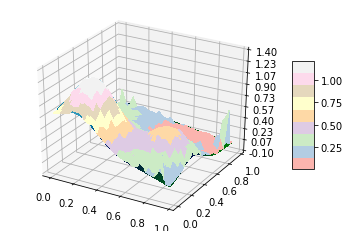

In [4]:
run Task_c.py

### Task d:

In [5]:
run Task_d.py

Accuracy score on test set:  0.9527777777777777
0.9528
Accuracy score on training set:  1.0
1.0000


### Task e:

In [6]:
run Task_e.py

/Users/Julian/ML-projects/project2/Task_e.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 5, i+1)


Training accuracy: 0.9902574809
Test accuracy: 0.9555555556


# Scikit-Learn Neural Network

### Loading the MNIST digit dataset:

/Users/Julian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


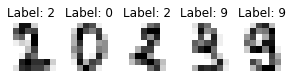

In [7]:
np.random.seed(2021)
digits = datasets.load_digits()

inputs = digits.images
labels = digits.target
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)

indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Label: %d' % digits.target[random_indices[i]])
plt.show()

/Users/Julian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Julian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Julian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Julian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't conver

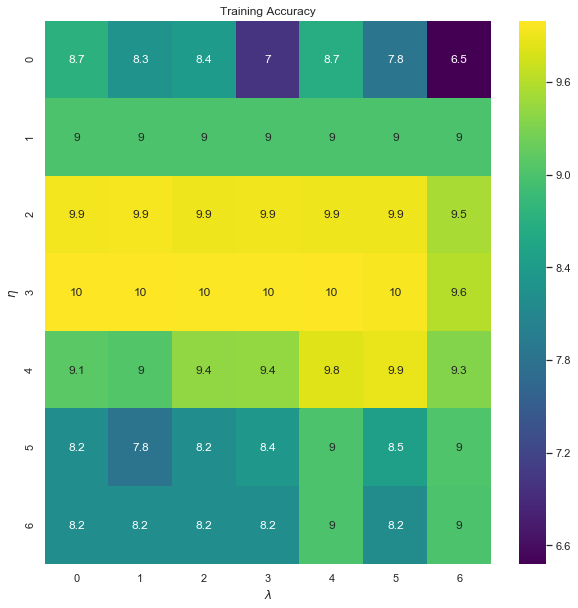

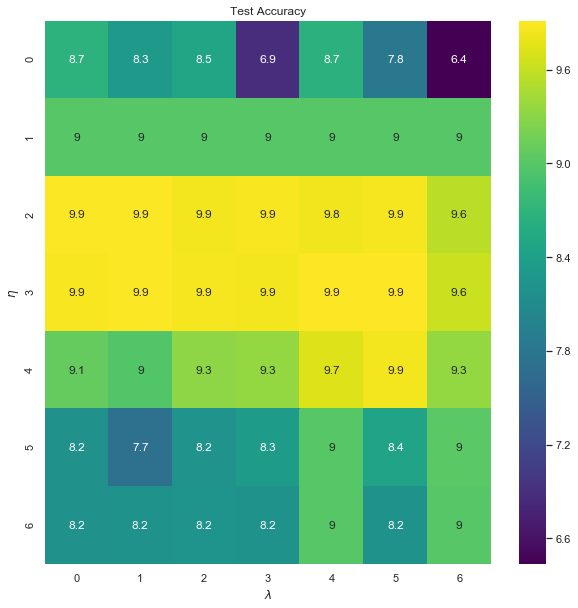

In [8]:
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
epochs = 100
n_hidden_neurons = 50
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()

# store models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        
        DNN_scikit[i][j] = dnn
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)
        
        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

# Neural Network using TensorFlow and Keras:

### Using the MNIST digit dataset

In [9]:
np.random.seed(2021)
digits = datasets.load_digits()

inputs = digits.images
labels = digits.target
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)

indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

# one-hot representation of labels
labels = to_categorical(labels)

# split into train and test data
train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[1.0, 0.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
12/12 [==============================] - 0s 1ms/step - loss: 2.0525 - accuracy: 0.6833
################################################
0.01 0.0 train accuracy= 0.7091162204742432 test accuracy= 0.6833333373069763
12/12 [==============================] - 0s 937us/step - loss: 2.2068 - accuracy: 0.5361
################################################
0.01 0.001 train accuracy= 0.5845511555671692 test accuracy= 0.5361111164093018
12/12 [==============================] - 0s 887us/step - loss: 2.3861 - accuracy: 0.0889


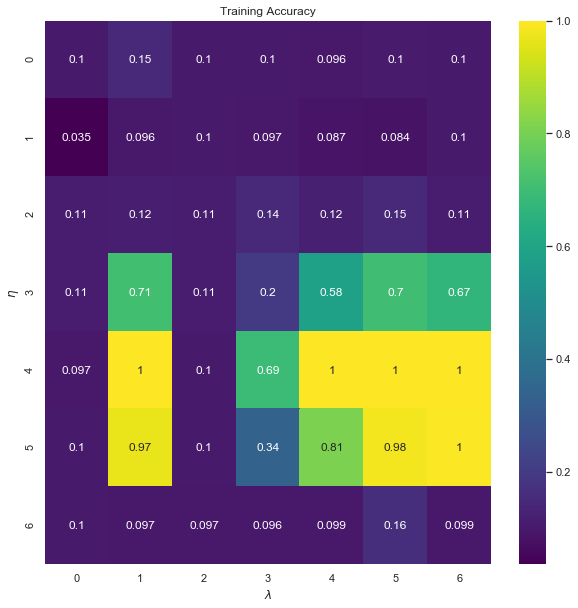

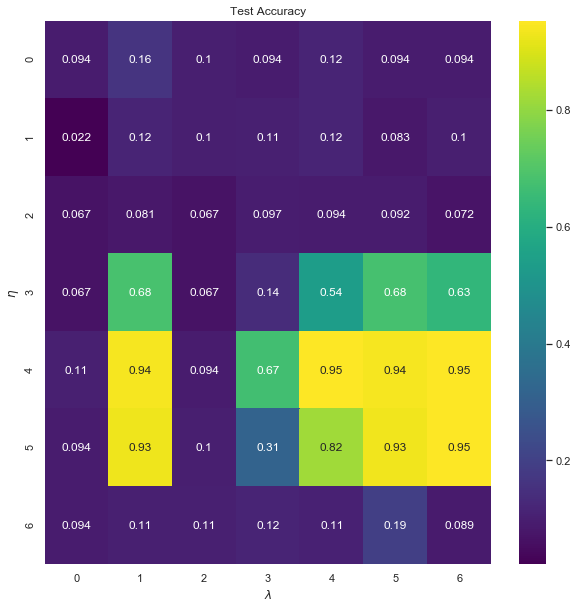

In [10]:
eta_vals = np.logspace(-5, 1, 7)
print(eta_vals)
lmbd_vals = [1.0,0.0,0.1,0.01,0.001,0.0001,0.00001]
print(lmbd_vals)
epochs = 100
batch_size = 50
sns.set()

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_Keras(n_neurons_layer1=50, n_neurons_layer2=50, n_neurons_layer3=50, n_categories=10,
                                         eta=eta, lmbd=lmbd, activation='softmax', activation_layers='sigmoid')
        DNN.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test, Y_test)
        
        DNN_keras[i][j] = DNN
        
        train_accuracy[i][j] = DNN.evaluate(X_train, Y_train)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test, Y_test)[1] 
        if(eta==0.01 and lmbd==0):
            print("################################################")
            print(eta, lmbd, "train accuracy=",train_accuracy[i][j], "test accuracy=", test_accuracy[i][j])
        if(eta==0.01 and lmbd==0.001):
            print("################################################")
            print(eta, lmbd, "train accuracy=",train_accuracy[i][j], "test accuracy=", test_accuracy[i][j])   


fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()